# ROMMA Scraping again

Almoset everyoune knows that you can get time series by scraping pages.


https://www.infoclimat.fr/climatologie/normales-records/1981-2010/grenoble-lvd/valeurs/38538002.html

http://romma.fr/station_24.php?id=4&tempe=1

In [3]:
import matplotlib.pyplot as plt
import numpy as np 
import re
import time
import requests
import html


In [4]:
pp = re.compile('station_24\.php\?id=(\d+)"><b>(.*?),')
user_agent = {'User-agent': 'Mozilla/5.0'}

url = 'http://romma.fr/frame_station24.php'

r = requests.get('http://romma.fr', 
                 headers=user_agent)

stations = pp.findall(r.text)

In [298]:
code, name = zip(*stations)

In [302]:
print(' '.join( [html.unescape(x) for x in name]) )

  BREGNIER-CORDON   VIRIAT   PONT-D'AIN   ST-ÉTIENNE-DU-BOIS   AMBÉRIEU-EN-BUGEY   BRIORD   LEAZ   INNIMOND   LELEX   LA VATTAY   SORGIA   MONTOISEY   SISTERON   DIGNE-LES-BAINS   ANNOT   LA JAVIE   SELONNET   LE VERNET   SEYNE - LE GRAND PUY   SEYNE - LE FAUT   CHABANON   ST-PAUL-SUR-UBAYE   HAUT-CHABANON   GAP   LA BEAUME   EYGLIERS   LA FREISSINOUSE   ST-LEGER-LES-MELEZES   ORCIÈRES-CHAUFFAREL   ORCIÈRES-LES TOURRENGS   LES ORRES   PUY-SAINT-PIERRE   ORCIÈRES   SAINT-VÉRAN   COL DU LAUTARET   PLATEAU DE BURE   NICE   VENCE   TOURRETTE-LEVENS   CLANS   ST-VALLIER-DE-THIEY   CIPIÈRES   ILONSE   GRAVESON   BOURG-LES-VALENCE   GRANGES-LES-BEAUMONT   AOUSTE-SUR-SYE   MONTBRISON-SUR-LEZ   CREST   ST-SORLIN-EN-VALLOIRE   LE PÈGUE   PEYRUS   RECOUBEAU   TESSIÈRRES   ST-AGNAN-EN-VERCORS   POMMEROL   LE VERSOUD   ST-MARTIN-D'HÈRES   BOUVESSE-QUIRIEU   VEYRINS-THUELLIN   L'ISLE-D'ABEAU   TREPT   ST-VÉRAND   VIZILLE   VOIRON   FARAMANS   ST-BLAISE-DU-BUIS   ST-JOSEPH-DE-RIVIERE   ST-LAURENT-DU-

## Extracting the data arrays

The good stuff is hiden in a frame but is easily accesible

In [99]:
def html2arrays(txt):
    def val2float(x):
        if x == '':
            return float('nan')
        return float(x)

    #I was dumping this from chrome and it  imposes fixed line widths
    #txt = re.sub('=\n','',txt)

    #json style null->nan
    #because we are going to cast string to float later
    txt = re.sub('null', 'nan', txt)

    pp = re.compile( 'var ([\w|\s]*?)array=.*?\[(.*?)\]', re.DOTALL)
    mm = pp.findall(txt)

    data = dict(mm)
    data.keys()

    fields = ['time', 'temp', 'pluie', 'intenspluie', 
              'pression', 'hum', 'rad','rafale','vent','ventdir']
    arrays = {}
    for key in fields:
       
        try:
            arrays[key] = np.array( [ val2float(x) for x in data[key].split(',')])
        except:
            print(key)
    
    return arrays
        
def get_station(ref_num=6):       
    url = 'http://romma.fr/frame_station24.php'
    user_agent = {'User-agent': 'Mozilla/5.0'}
    
    r = requests.post(url, 
                     headers=user_agent,
                     params={"id_station":ref_num, "tempe":1})
    
    return r.text
    
tt = get_station(ref_num=4)
meteo = html2arrays(tt)
        

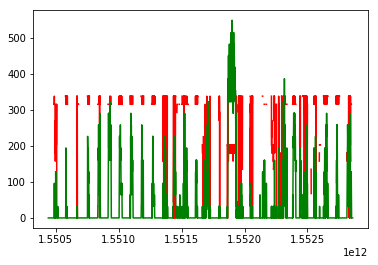

In [100]:
ww = 28*24*6
plt.plot(meteo['time'][-ww:], meteo['ventdir'][-ww:],'r')
plt.plot( meteo['time'][-ww:], meteo['vent'][-ww:]*20,'g')

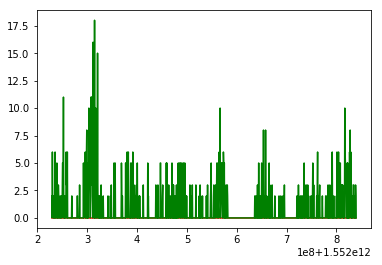

In [30]:
ww = 7*24*6
plt.plot(meteo['time'][-ww:], meteo['rafale'][-ww:],'r')
#plt.plot(tt[-ww:],np.diff(temp,n=1)[-ww:],'b')
plt.plot( meteo['time'][-ww:], meteo['vent'][-ww:],'g')

    

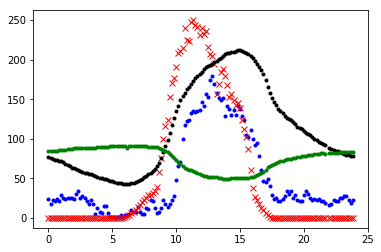

In [108]:
def hour(x):
    tt = time.localtime(x/1000)
    return tt.tm_hour + tt.tm_min/60
    

def tot(key='rad'):
    day = 24*6
    tot = np.zeros((day), dtype=np.float32)
    for k in range(28):
        tot += np.roll(meteo[key], k*day)[:day]
    return tot
    
times = [hour(x) for x in meteo['time'][:day]]
    
plt.plot( times,tot(key='vent'),'b.')
plt.plot( times ,tot(key='rad')/50,'rx')
plt.plot( times ,tot(key='temp')/2,'k.')
plt.plot( times ,tot(key='hum')/28,'g.')

In [98]:
numdays = 21
ts = [i for i in range(-1,-1 - numdays*24*6, -24*6)]

day_intervals = [list(zip(meteo['temp'],meteo['time']))[i:j] for i,j in  zip(ts[1:],ts)]
mx = [max(day) for day in day_intervals if day]
x,y = zip(*mx)
[time.ctime(t/1000.) for t in y]

['Sun Mar 17 13:20:00 2019',
 'Sat Mar 16 16:50:00 2019',
 'Fri Mar 15 16:50:00 2019',
 'Thu Mar 14 12:40:00 2019',
 'Tue Mar 12 22:40:00 2019',
 'Tue Mar 12 15:10:00 2019',
 'Sun Mar 10 21:50:00 2019',
 'Sun Mar 10 15:30:00 2019',
 'Sat Mar  9 11:50:00 2019',
 'Fri Mar  8 14:50:00 2019',
 'Wed Mar  6 23:50:00 2019',
 'Wed Mar  6 14:10:00 2019',
 'Tue Mar  5 16:10:00 2019',
 'Mon Mar  4 14:10:00 2019',
 'Sun Mar  3 14:50:00 2019',
 'Sat Mar  2 12:30:00 2019',
 'Fri Mar  1 11:50:00 2019',
 'Thu Feb 28 15:00:00 2019',
 'Wed Feb 27 15:30:00 2019',
 'Tue Feb 26 16:00:00 2019']

In [1]:
XS, YS = zip(*mx)
YS = [(int(y)//1000 % (24*3600)) /3600 for y in YS]
plt.plot(YS,XS, 'rx')

NameError: name 'mx' is not defined

In [313]:
night = meteo['time'][meteo['rad'] == 0]
xx = stuff[:-1][np.diff(night)  > 600000]

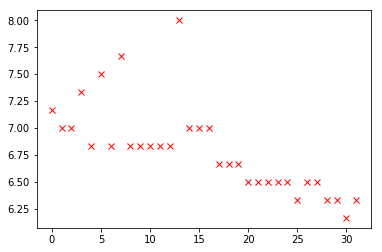

In [317]:
trans = [int(y)//1000 % (24*3600) /3600 for y in xx]
trans = [ min(x,8) for x in trans ]

plt.plot(range(len(trans)),trans,'rx')